In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import date, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, YearLocator, WeekdayLocator, DateFormatter
import calendar
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data scraping

In [2]:
company = 'ALK'
year_start=2012
year_end=date.today().year #2014

In [3]:
def get_list_of_date_ranges(year_start=2012, year_end=date.today().year):
  todays_date = date.today()
  years = np.arange(year_start,year_end+1)
  first_day='01-01-'
  last_day='31-12-'
  list_of_date_ranges = []
  for year in years:
    list_of_date_ranges.append(first_day+str(year))
    list_of_date_ranges.append(last_day+str(year))
  return list_of_date_ranges

In [4]:
list_of_date_ranges = get_list_of_date_ranges(year_start, year_end)
url_str_list=[]
for idx in range(0, len(list_of_date_ranges)-1, 2):
  url_str = 'https://www.mse.mk/mk/stats/symbolhistory/' + company + '?FromDate=' + list_of_date_ranges[idx] + '&ToDate=' + list_of_date_ranges[idx+1]
  url_str_list.append(url_str)
url_str_list

['https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2012&ToDate=31-12-2012',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2013&ToDate=31-12-2013',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2014&ToDate=31-12-2014',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2015&ToDate=31-12-2015',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2016&ToDate=31-12-2016',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2017&ToDate=31-12-2017',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2018&ToDate=31-12-2018',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2019&ToDate=31-12-2019',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2020&ToDate=31-12-2020',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2021&ToDate=31-12-2021',
 'https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2022&ToDate=31-12-2022']

In [5]:
list_tablesForEachYear = []
df = pd.DataFrame(columns=['Datum', 'CenaPoslednaTransakcija', 'Max', 'Min', 'ProsecnaCena', 'ProcProm', 'Kolicina', 'PrometBEST', 'PrometVkupen'])
print('Loading data...')
for url in url_str_list:
  page = requests.get(url)
  if page.status_code == 200:
    print(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    html = list(soup.children)[3]
    body = list(html.children)[3]
    table = soup.find("table", {"id": "resultsTable"})
    for row in table.tbody.find_all('tr'):    
        # Find all data for each column
        columns = row.find_all('td')
        if(columns != []):
            df = df.append({'Datum'                   : columns[0].text.strip(),
                            'CenaPoslednaTransakcija' : columns[1].text.strip(), 
                            'Max'                     : columns[2].text.strip(), 
                            'Min'                     : columns[3].text.strip(), 
                            'ProsecnaCena'            : columns[4].text.strip(), 
                            'ProcProm'                : columns[5].text.strip(), 
                            'Kolicina'                : columns[6].text.strip(), 
                            'PrometBEST'              : columns[7].text.strip(), 
                            'PrometVkupen'            : columns[8].text.strip()}, 
                          ignore_index=True)
print('Done.')

Loading data...
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2012&ToDate=31-12-2012
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2013&ToDate=31-12-2013
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2014&ToDate=31-12-2014
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2015&ToDate=31-12-2015
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2016&ToDate=31-12-2016
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2017&ToDate=31-12-2017
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2018&ToDate=31-12-2018
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2019&ToDate=31-12-2019
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2020&ToDate=31-12-2020
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2021&ToDate=31-12-2021
https://www.mse.mk/mk/stats/symbolhistory/ALK?FromDate=01-01-2022&ToDate=31-12-2022
Done.


## Preprocessing data

In [6]:
final_df = df.copy()

In [7]:
for column in final_df.columns:
  if column == 'Datum':
    final_df['Datum'] = pd.to_datetime(final_df['Datum'], format='%d.%m.%Y')
    continue
  if final_df[column].dtype == np.float64 or final_df[column].dtype == np.int64:
    continue
  final_df[column] = final_df[column].str.replace('.', '', regex=False)
  final_df[column] = final_df[column].str.replace(',', '.', regex=False)
  final_df[column] = final_df[column].replace(r'^\s*$', 0, regex=True)
  final_df[column] = final_df[column].astype(float)
  
final_df.sort_values(by=['Datum'], ascending=True, inplace=True)
final_df.reset_index(inplace=True, drop=True)
final_df = final_df.set_index('Datum')

In [8]:
final_df.dtypes

CenaPoslednaTransakcija    float64
Max                        float64
Min                        float64
ProsecnaCena               float64
ProcProm                   float64
Kolicina                   float64
PrometBEST                 float64
PrometVkupen               float64
dtype: object

In [9]:
final_df.describe()

,CenaPoslednaTransakcija,Max,Min,ProsecnaCena,ProcProm,Kolicina,PrometBEST,PrometVkupen
count,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2.477000e+03,2.477000e+03
mean,7622.504643,7486.639887,7434.131207,7619.941522,0.067562,257.169964,1.973666e+06,2.149907e+06
std,3926.130789,4052.215761,4009.024591,3923.196706,0.984139,453.023256,3.613452e+06,4.817292e+06
min,3822.000000,0.000000,0.000000,3834.080000,-10.000000,0.000000,0.000000e+00,0.000000e+00
25%,4500.000000,4452.000000,4430.000000,4500.140000,-0.190000,67.000000,4.180000e+05,4.227070e+05
50%,5490.000000,5451.000000,5426.000000,5483.000000,0.010000,149.000000,9.713050e+05,9.793350e+05
75%,9148.000000,9100.000000,9051.000000,9131.250000,0.380000,300.000000,2.296000e+06,2.314800e+06
max,19400.000000,19400.000000,19350.000000,19382.060000,9.050000,7960.000000,6.406287e+07,9.227817e+07


In [10]:
final_df.to_csv(company+'_MKBerza.csv')

## Visualization

In [11]:
input_df = pd.read_csv(company+'_MKBerza.csv', index_col=0)
input_df

,CenaPoslednaTransakcija,Max,Min,ProsecnaCena,ProcProm,Kolicina,PrometBEST,PrometVkupen
Datum,,,,,,,,
2012-01-03,3950.0,3950.0,3900.0,3914.65,-0.35,40.0,156586.0,156586.0
2012-01-04,3901.0,3910.0,3900.0,3901.59,-0.33,205.0,799825.0,799825.0
2012-01-05,3910.0,3910.0,3902.0,3906.43,0.12,341.0,1332092.0,1332092.0
2012-01-09,3860.0,3925.0,3860.0,3907.55,0.03,284.0,1109745.0,1109745.0
2012-01-10,3900.0,3900.0,3900.0,3900.00,-0.19,170.0,663000.0,663000.0
...,...,...,...,...,...,...,...,...
2022-01-28,18748.0,19000.0,18101.0,18716.91,0.74,90.0,1684522.0,1684522.0
2022-01-31,18550.0,18900.0,18550.0,18842.10,0.67,49.0,923263.0,923263.0
2022-02-01,18650.0,18850.0,18650.0,18846.37,0.02,60.0,1130782.0,1130782.0


### Histograms

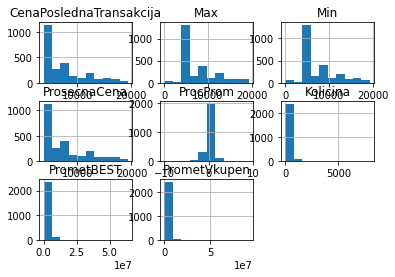

In [12]:
input_df.hist()
plt.show()

### Moving average

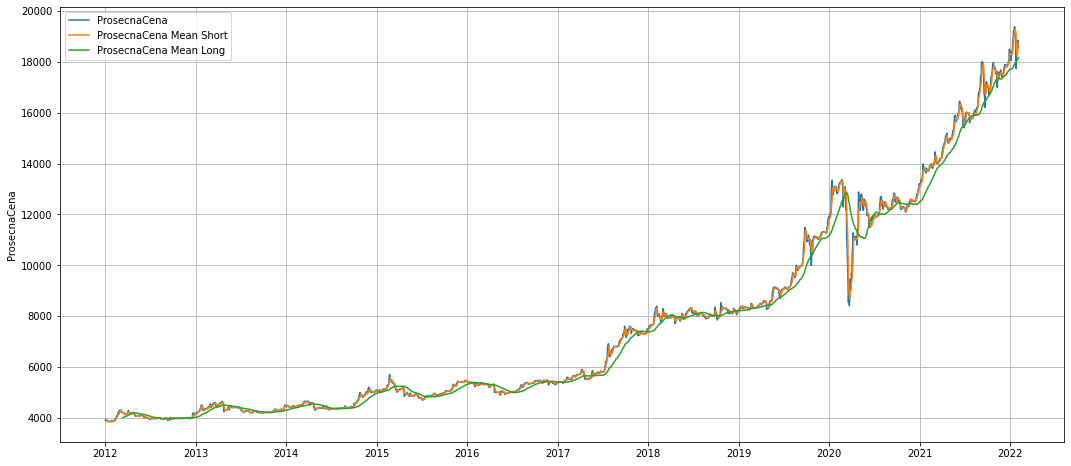

In [13]:
date=[]
for value in input_df.index.values:
  date.append(date2num(datetime.strptime(value, '%Y-%m-%d')))
  
input_df['ProsecnaCena_Mean_Short'] = input_df['ProsecnaCena'].rolling(window=5).mean()
input_df['ProsecnaCena_Mean_Long'] = input_df['ProsecnaCena'].rolling(window=50).mean()

plt.figure(figsize=(18,8))
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
line1, = ax.plot(date, input_df['ProsecnaCena'],            label='ProsecnaCena')
line2, = ax.plot(date, input_df['ProsecnaCena_Mean_Short'], label='ProsecnaCena Mean Short')
line3, = ax.plot(date, input_df['ProsecnaCena_Mean_Long'],  label='ProsecnaCena Mean Long')
ax.legend(handles=[line1, line2, line3])
plt.grid(True)
plt.ylabel('ProsecnaCena')
plt.show()

We want to buy stocks when the short mean average is higher than the long mean average value.

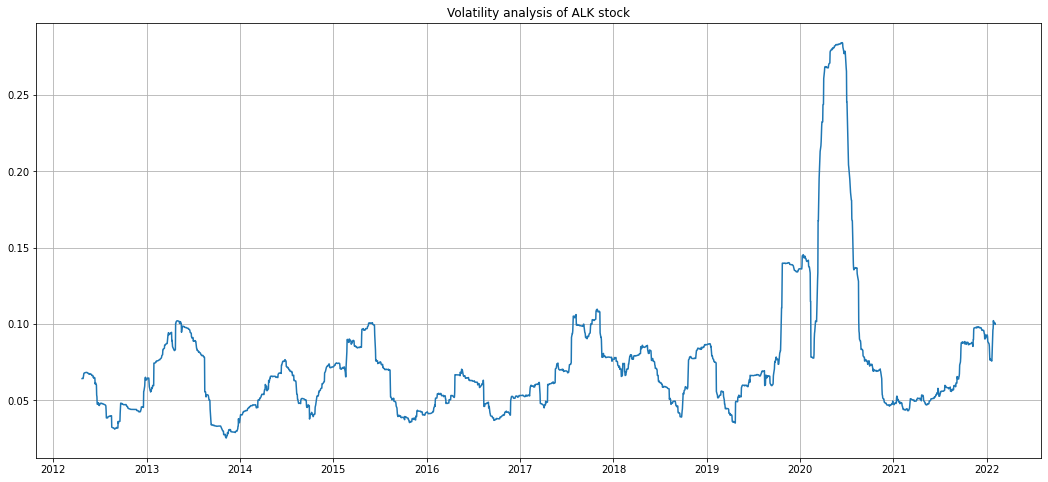

In [14]:
prosecnaCena_pc = input_df['ProsecnaCena'].pct_change()
vol = prosecnaCena_pc.rolling(75).std()*np.sqrt(75)


plt.figure(figsize=(18,8))
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
plt.plot(date, vol)
plt.grid(True)
plt.title('Volatility analysis of ' + company + ' stock')
plt.show()


In [15]:
input_df_copy = input_df.copy()
input_df_copy.index = pd.to_datetime(input_df_copy.index)

In [16]:
df_month = input_df_copy.resample("M").mean()
df_month.head()

,CenaPoslednaTransakcija,Max,Min,ProsecnaCena,ProcProm,Kolicina,PrometBEST,PrometVkupen,ProsecnaCena_Mean_Short,ProsecnaCena_Mean_Long
Datum,,,,,,,,,,
2012-01-31,3868.842105,3883.473684,3861.421053,3872.194211,-0.078421,138.789474,5.378970e+05,5.378970e+05,3866.400267,NaN
2012-02-29,4028.809524,4034.380952,3999.714286,4020.055714,0.407619,187.000000,7.527391e+05,7.527391e+05,3988.262286,NaN
2012-03-31,4197.545455,4016.818182,4000.727273,4199.472727,-0.053636,177.181818,7.462468e+05,7.462468e+05,4204.979636,4043.276292
2012-04-30,4202.789474,4212.052632,4195.052632,4200.546842,-0.072632,433.473684,1.820108e+06,1.820108e+06,4199.755053,4144.138611
2012-05-31,4071.809524,4081.952381,4064.809524,4075.028571,-0.000952,406.238095,1.659390e+06,1.659390e+06,4080.660571,4166.167362


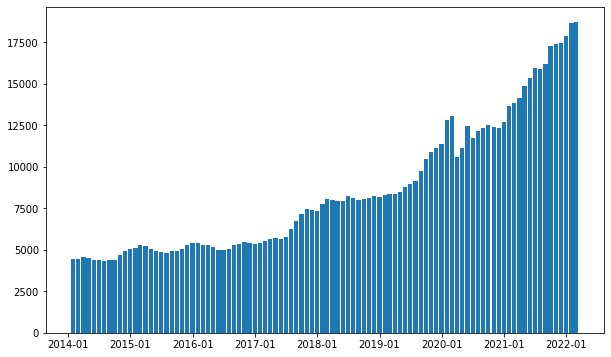

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.bar(df_month['2014':].index, df_month.loc['2014':, "ProsecnaCena"], width=25, align='center')
plt.show()

In [18]:
df_week = input_df_copy.resample("W").mean()	
df_week.head()

,CenaPoslednaTransakcija,Max,Min,ProsecnaCena,ProcProm,Kolicina,PrometBEST,PrometVkupen,ProsecnaCena_Mean_Short,ProsecnaCena_Mean_Long
Datum,,,,,,,,,,
2012-01-08,3920.333333,3923.333333,3900.666667,3907.556667,-0.186667,195.333333,762834.333333,762834.333333,NaN,NaN
2012-01-15,3862.600000,3876.800000,3862.400000,3872.640000,-0.284000,161.200000,625695.200000,625695.200000,3889.0020,NaN
2012-01-22,3855.500000,3878.000000,3853.000000,3862.237500,0.057500,110.250000,425559.500000,425559.500000,3858.7065,NaN
2012-01-29,3854.400000,3864.000000,3840.200000,3853.348000,0.084000,122.600000,471645.200000,471645.200000,3854.6912,NaN
2012-02-05,3862.000000,3880.000000,3862.000000,3871.870000,-0.032000,112.200000,434712.000000,434712.000000,3869.6612,NaN


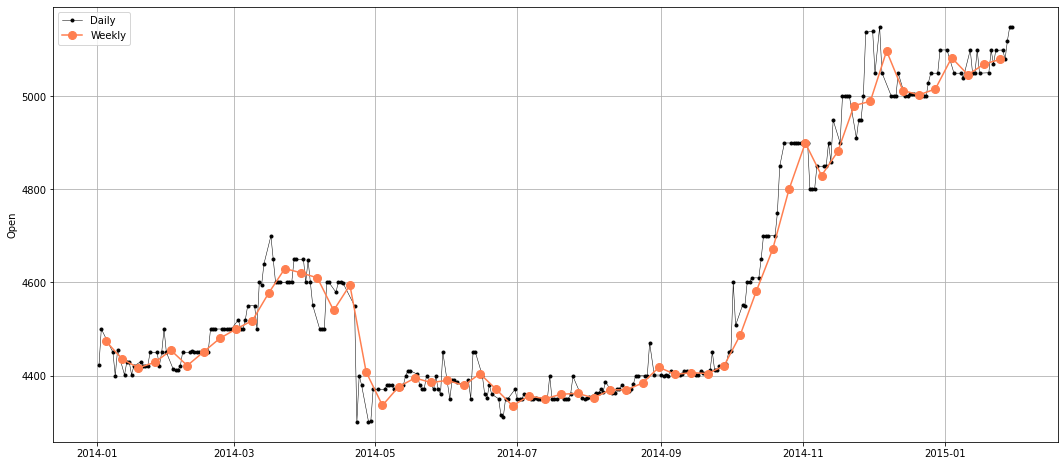

In [19]:
start, end = '2014-01', '2015-01'
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(input_df_copy.loc[start:end, 'CenaPoslednaTransakcija'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'CenaPoslednaTransakcija'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.set_ylabel("Open")
ax.legend()
plt.grid(True)
plt.show()

The weekly average plot has smaller spikes than daily data.

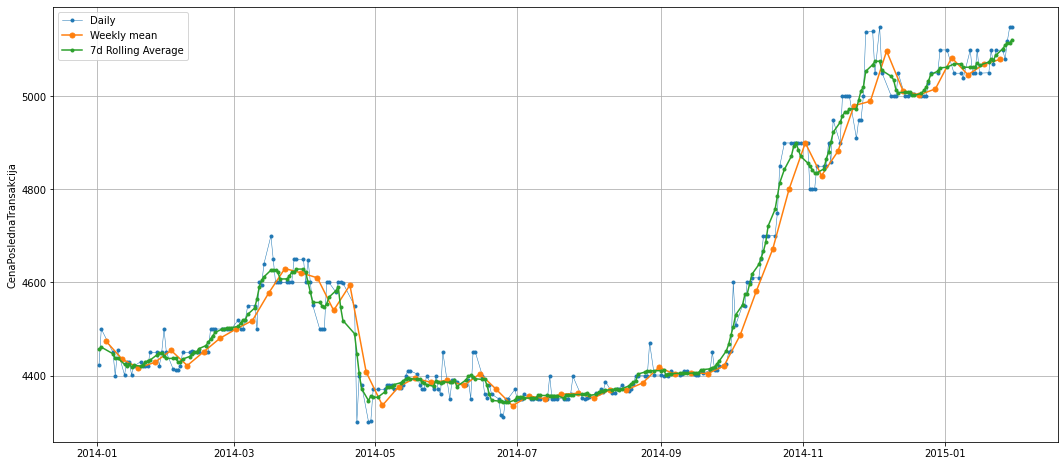

In [20]:
df_7d_rolling = input_df_copy.rolling(7, center=True).mean()
start, end = '2014-01', '2015-01'
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(input_df_copy.loc[start:end, 'CenaPoslednaTransakcija'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'CenaPoslednaTransakcija'], marker='o', markersize=5, linestyle='-', label = 'Weekly mean')
ax.plot(df_7d_rolling.loc[start:end, 'CenaPoslednaTransakcija'], marker='.', linestyle='-', label='7d Rolling Average')
ax.set_ylabel('CenaPoslednaTransakcija')
ax.legend()
plt.grid(True)
plt.show()

7-d rolling average is a bit smoother than the weekly average.

### Expanding Window  
It keeps adding the cumulative

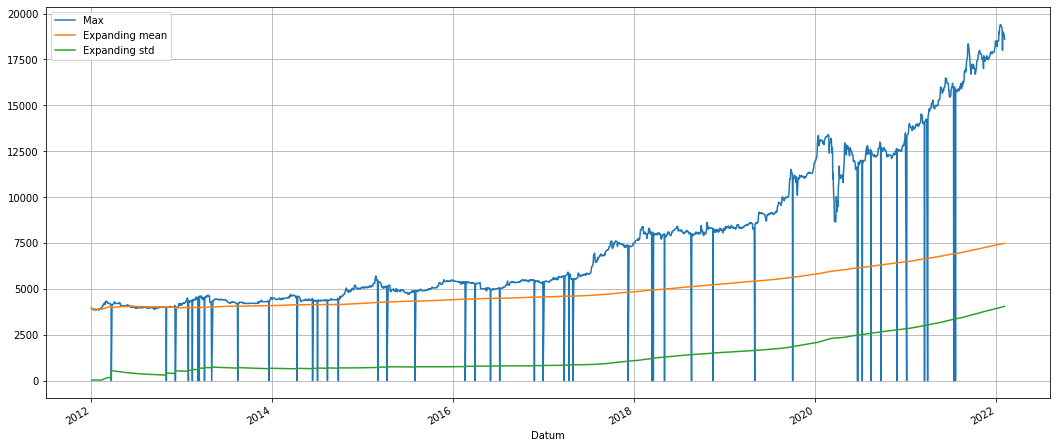

In [21]:
fig, ax = plt.subplots(figsize=(18,8))
ax = input_df_copy['Max'].plot(label='Max')
ax = input_df_copy['Max'].expanding().mean().plot(label='Expanding mean')
ax = input_df_copy['Max'].expanding().std().plot(label='Expanding std')
ax.legend()
plt.grid(True)
plt.show()

Heat map

In [22]:
all_month_year_df = input_df_copy.pivot_table(values='ProsecnaCena',
                                              index=pd.DatetimeIndex(input_df_copy.index.values).month,
                                              columns=pd.DatetimeIndex(input_df_copy.index.values).year,
                                              fill_value=0,
                                              margins=False)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Jan,3872.194211,4301.207143,4442.799500,5083.223333,5387.922941,5408.438947,7762.521000,8330.163810,12842.685500,13663.718824,18675.194444
Feb,4020.055714,4370.302500,4462.006000,5289.458000,5310.958095,5529.758000,8039.197500,8348.043500,13049.771500,13866.596500,18713.670000
Mar,4199.472727,4505.360952,4586.114762,5238.355000,5307.437826,5666.448261,8028.470455,8367.014286,10600.951364,14148.027391,0.000000
Apr,4200.546842,4502.126364,4510.959000,5063.748000,5197.342000,5681.967222,7917.724211,8502.136000,11129.328500,14843.000000,0.000000
May,4075.028571,4389.617368,4386.412381,4905.930000,4997.927000,5623.535238,7936.425000,8808.884286,12454.853684,15379.770000,0.000000
Jun,4005.151500,4405.441579,4371.793000,4854.638182,4978.014286,5779.143500,8212.367000,8978.555000,11754.811905,15939.819048,0.000000
Jul,3970.765455,4269.478696,4353.951364,4790.711818,5057.504000,6258.406667,8106.822273,9121.315217,12135.759545,15864.734091,0.000000
Aug,3973.829000,4229.820000,4383.929000,4899.564737,5290.866364,6726.650952,8001.056667,9726.317000,12331.711579,16209.521429,0.000000
Sep,3952.751500,4218.443500,4411.133333,4933.450952,5363.930476,7167.604500,8051.405500,10464.349500,12500.377619,17261.025714,0.000000
Oct,3997.664762,4209.364762,4703.178182,5050.134500,5444.251053,7431.821000,8120.330000,10906.236667,12386.704000,17370.212000,0.000000


In [23]:
rcParams['figure.figsize'] = 15, 10

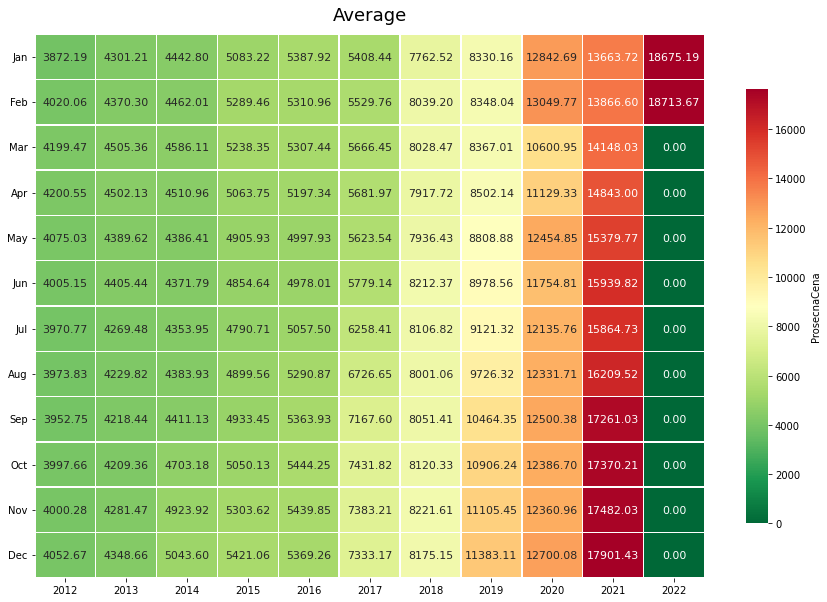

In [24]:
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'ProsecnaCena'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average', fontdict={'fontsize':18},    pad=14);

Darker red means very high ProsecnaCena and dark green mean very low ProsecnaCena.

### Decomposition
Decomposition will show the observations and these three elements in the same plot:  
Trend: Consistent upward or downward slope of a time series.  
Seasonality: Clear periodic pattern of a time series  
Noise: Outliers or missing values  
Original observations = Trend + Seasonality + Residuals

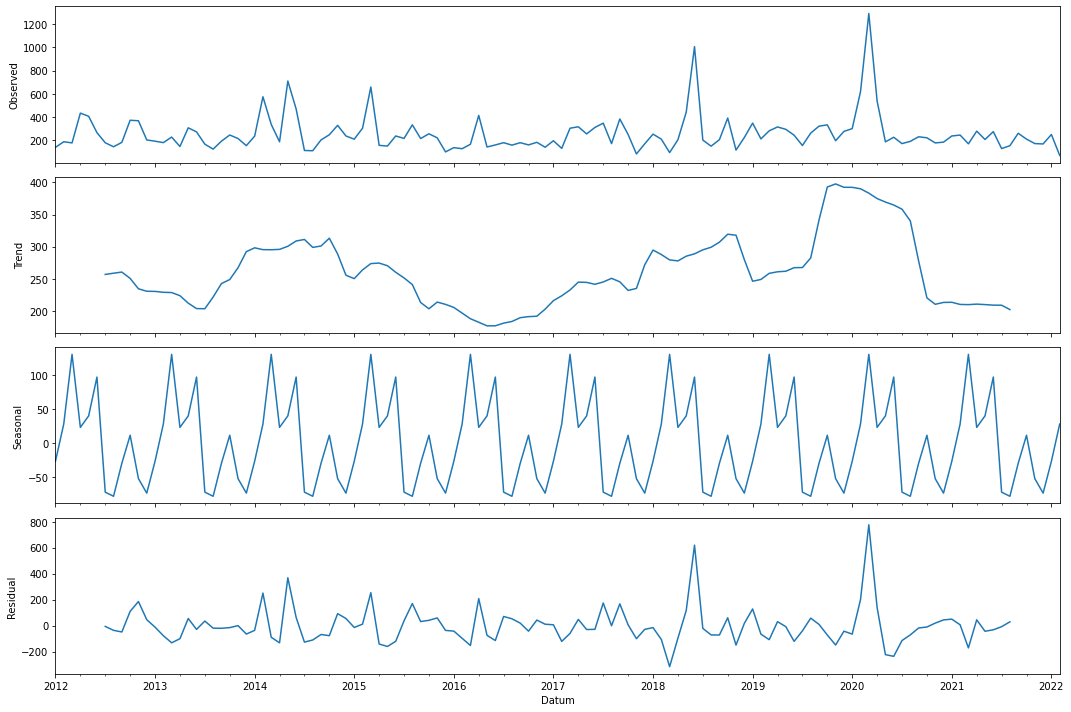

In [25]:
decomposition = sm.tsa.seasonal_decompose(df_month['Kolicina'], model='Additive')
fig = decomposition.plot()
plt.show()